In [1]:
# from IPython.display import IFrame
# IFrame('http://nycha.maps.arcgis.com/apps/webappviewer/index.html?id=41c6ff5e73ec459092e982060b7cf1a1', 
#        width=900, height=750)

In [2]:
import pandas as pd
from shapely.geometry import Point
import datetime as dt
import geopandas as gpd
from fiona.crs import from_epsg
import pyproj
import pylab as pl

import mplleaflet
import folium

%pylab inline
# dt.datetime.fromtimestamp(1493847850121.0/1000)

Populating the interactive namespace from numpy and matplotlib


# 1. Wifi_Scan Data

In [3]:
# Read File
df = pd.read_csv("/home/dj/Desktop/motoG4_062212.csv")
# convert Unix timestamp into readable timestamp
df['time2'] = map(lambda x: dt.datetime.fromtimestamp(x), df.time.astype(float)/1000)
df['month'] = map(lambda x: x.month, df['time2'])
df['day'] = map(lambda x: x.day, df['time2'])
df['hour'] = map(lambda x: x.hour, df['time2'])
df['minute'] = map(lambda x: x.minute, df['time2'])
df['sec'] = map(lambda x: x.second, df['time2'])

In [4]:
'''
df2 -> Data Collected on 06/14/2017 by 'Moto G (4)'
including 3 housing project:
- Fulton
- Eliot
- Chelsea
'''

# Filter
df2 = df.copy()
df2 = df2[((df2['month'] == 6) & (df2['day'] == 14)) | ((df2['month'] == 6) & (df2['day'] == 22) & (df2['hour'] <10))]
print "df2.shape: ", df2.shape
print "df2 unique time: ", df2.time.unique().shape

# Transform to geo format
df2.reset_index(drop=True, inplace=True)
df2['geo'] = zip(df2.lng, df2.lat)
df2['geometry'] = map(lambda x: Point(x), zip(df2.lng, df2.lat))

# Prove: with the same timestamp, one ssid may have more than one bssid.
# Conclusion: use 'bssid' unique value to count accessible wifi signals instead of 'ssid'. 
# access -> bssid
print "df2 unique bssid: ", df2.bssid.unique().shape; print "df2 unique ssid: ", df2.ssid.unique().shape
print df2.groupby(df2.time).apply(lambda x: x.groupby(x.ssid).apply(lambda x: len(x.bssid)))[:2]

df2.shape:  (239603, 21)
df2 unique time:  (2904,)
df2 unique bssid:  (5972,)
df2 unique ssid:  (3715,)
time           ssid          
1497478151773  #meatpackingny    9
               5252              1
dtype: int64


In [5]:
# groupby and agg
access_count = df2.groupby(df2.geo).apply(lambda x: len(x.bssid.unique()))
access_bssidList = df2.groupby(df2.geo).apply(lambda x: list(x.bssid.unique()))

df3 = pd.DataFrame(map(lambda x: Point(x), access_count.index), columns=['geometry'])
df3['unique_bssid_count'] = access_count.values
df3['unique_bssid_list'] = access_bssidList.values

# convert DataFrame -> GeoDataFrame
# Original 'epsg':4326
# to 'epsg': 2263 -> usft
df3= gpd.GeoDataFrame(df3)
df3.crs = from_epsg(4326)
df3.to_crs(epsg=2263, inplace=True)
print 'df3 shape: ', df3.shape
df3.head(2)

df3 shape:  (2904, 3)


,geometry,unique_bssid_count,unique_bssid_list
0,POINT (982258.3821567033 210039.377046411),61,"[86:15:54:67:bb:e8, 86:15:44:67:bb:e8, 2c:30:3..."
1,POINT (982258.8944514482 210035.2017612456),61,"[86:15:54:67:bb:e8, 86:15:44:67:bb:e8, 2c:30:3..."


In [8]:
df3.to_pickle('unique_bssid.p')

<br/>
# 2. Housing Project Data
- https://data.cityofnewyork.us/Housing-Development/Map-of-NYCHA-Developments/i9rv-hdr5/data
- https://data.cityofnewyork.us/Housing-Development/NYCHA-GIS-file/tqnb-xmxw/data

Offical Names of my target housing projects are:
- FULTON
- CHELSEA
- CHELSEA ADDITION
- ELLIOTT

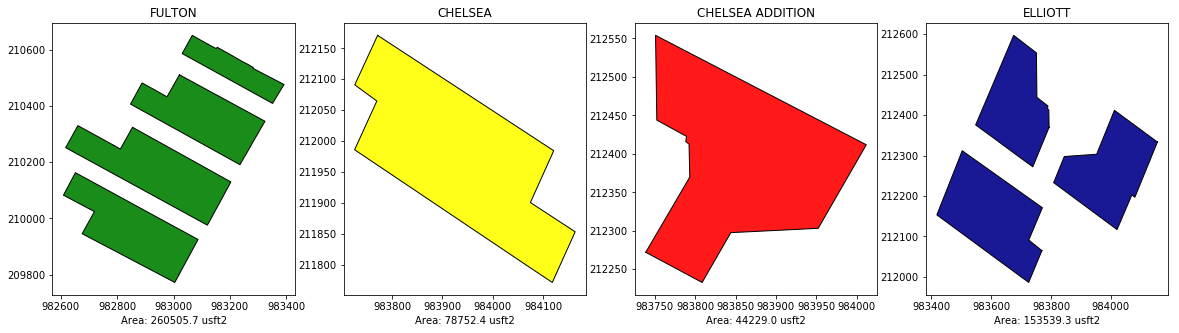

In [6]:
# geo data
hp_geo = gpd.read_file("./NYCHA/geo_export_f8e33e41-d8a4-4a67-8445-6472b630d185.shp")
hp_geo.to_crs(epsg=2263, inplace=True)

# names
hp_list = ['FULTON', 'CHELSEA', 'CHELSEA ADDITION', 'ELLIOTT']
hp_target = hp_geo[hp_geo.developmen.isin(hp_list)]

# shapes
fig, (ax1,ax2,ax3,ax4) = pl.subplots(1,4,figsize=(20,5))
d_ax = {'ax1':ax1, 'ax2':ax2, 'ax3':ax3, 'ax4':ax4}
col_ax = ['green', 'yellow', 'red', 'darkblue']
for i in range(4):
    hp_geo[hp_geo.developmen == hp_list[i]].plot(ax=d_ax['ax'+str(i+1)], color=col_ax[i], alpha=0.9)
    d_ax['ax'+str(i+1)].set_title(hp_list[i])
    d_ax['ax'+str(i+1)].set_xlabel('Area: ' + str(round(hp_geo[hp_geo.developmen == hp_list[i]].geometry.area.values[0], 1))+" usft2")

In [10]:
# mplleaflet.display(fig=ax1.figure, crs=hp_geo.crs)
# web page
# mplleaflet.show(fig=d_ax['ax'+str(i)].figure, crs=hp_geo.crs)

In [7]:
import warnings; warnings.simplefilter('ignore')
hp_target['style'] = [
    {'fillColor': 'yellow', 'weight': 1, 'color': 'black'},
    {'fillColor': 'red', 'weight': 1, 'color': 'black'},
    {'fillColor': 'darkblue', 'weight': 1, 'color': 'black'},
    {'fillColor': 'green', 'weight': 1, 'color': 'black'}]


m = folium.Map([40.743, -74], zoom_start=15, tiles='Stamen Toner', crs='EPSG3857')
folium.GeoJson(hp_target).add_to(m) # folium.plugins.HeatMap(hp_target.index).add_to(m)
m #m.save('geopandas.html')

    - "OpenStreetMap"
    - "Mapbox Bright" (Limited levels of zoom for free tiles)
    - "Mapbox Control Room" (Limited levels of zoom for free tiles)
    - "Stamen" (Terrain, Toner, and Watercolor)
    - "Cloudmade" (Must pass API key)
    - "Mapbox" (Must pass API key)
    - "CartoDB" (positron and dark_matter)
 ---
    - "OpenStreetMap"
    - "Stamen Watercolor"
    - "Stamen Toner"
    - "Cartodb Positron"
    - "Cartodb dark_matter"
    - customized tail: 
        - attr = ('&copy; <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> '
        'contributors, &copy; <a href="http://cartodb.com/attributions">CartoDB</a>')
        - tiles = 'http://{s}.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}.png'
        - eg: m = folium.Map([40.743, -74], zoom_start=15, tiles=tiles, attr=attr, crs='EPSG3857')
---
    - tiles:
    - from IPython.display import IFrame
    - IFrame('http://leaflet-extras.github.io/leaflet-providers/preview/', width=900, height=750)

<br/><br/>
## 3. Free Wifi


In [13]:
# Free Wifi List from last year capstone project

free_wifi = [
'#flatiron free wifi', 
'freewifibysurface',
'bryantpark.org', 
'DowntownBrooklynWiFi_Fon',
'linknyc free wi-fi', 
'Metrotech',
'usp park wifi', 
'Red Hook Wifi']

s1 = set(df2.ssid)
s2 = set(free_wifi)
s1.intersection(s2)

{'linknyc free wi-fi'}

In [14]:
# df4: 'free-wifi' records 
# df4 only contains records with ssid = 'linknyc free wi-fi'
df4 = df2.copy()
df4 = gpd.GeoDataFrame(df4)
df4 = df4[df4.ssid == 'linknyc free wi-fi']
df4.crs = from_epsg(4326)
df4.to_crs(epsg=2263, inplace=True)
df4['style']= [{'fillColor': 'yellow', 'weight': 1, 'color': 'black'}] * len(df4)

In [16]:
f, ax = pl.subplots(1,1,figsize=(5,5))
df4.plot(ax=ax)
mplleaflet.display(fig=ax.figure, crs=df4.crs)

In [17]:
df4.drop(['time2', 'geo'], axis=1).to_file('hp_plot')

In [20]:
#hp_target.to_pickle("hp_target.p")

In [21]:
# Points where free wifi signals are detected.
m2 = folium.Map([40.743, -74], zoom_start=15, tiles='Cartodb dark_matter', crs='EPSG3857', control_scale=False, max_zoom=30)
folium.GeoJson(df4.drop('time2', axis=1)).add_to(m2) # folium.plugins.HeatMap(hp_target.index).add_to(m)
folium.GeoJson(hp_target).add_to(m2)
m2

### Update Free Wifi ssid List (next step)

<br/><br/><br/>


## 4. Choropleth Maps
    - grid (select a reasonable size of grid)+ sjoin (data point) + count (unique bssid in each cell): 
        - for ALL wifi density
        - for example
![](https://camo.githubusercontent.com/deb90a0d1010a714d5324162ac47711a707279be/687474703a2f2f6661726d392e737461746963666c69636b722e636f6d2f383134302f383735343831373335355f326266656134336666355f632e6a7067)

---
    - grid + sjoin + median (level: signal strength - all points in one single cell)
        - for Free wifi signal strength
        - Based on Free wifi List (need to be update) 

## 5. Which CT / CB / Zipcode / Community / Neighborhood / Household do these housing projects belong to or contain?
    - shapefile
        - ct
        - cb
        - zipcode
        - household
        - ...
    - sjoin
    - merge dataframes

<br/><br/>
## 6. Demographic Data
    -level
        -ct
        -cb
        -zip
        -household

## 7. Story of Target Housing Projects: How come people built them?
    - FULTON
    - CHELSEA
    - CHELSEA ADDITION
    - ELLIOTT

## 8. Find out Expensive Apartment or Household Nearby ( or Other Public Facilities) 
    -For further comparision...

In [18]:
all_x = map(lambda p: p.x, df3.geometry)
all_y = map(lambda p: p.y, df3.geometry)

In [19]:
minx, maxx, miny, maxy = min(all_x), max(all_x), min(all_y), max(all_y) 

In [20]:
print minx, maxx, miny, maxy

982258.382157 984756.445048 209697.251114 212819.601834


In [37]:
print minx, maxx, miny, maxy

982258.382157 984092.587072 209697.251114 211755.438094
